In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Define the paths to your spectrogram folders
TRAIN_FOLDER = '/content/drive/My Drive/spectrogram_images_train/'
TEST_FOLDER = '/content/drive/My Drive/spectrogram_images_test/'

from PIL import Image

# Function to load images and labels
def load_data(folder):
    images = []
    labels = []

    # Get the list of subdirectories (bird species)
    subdirectories = [f.path for f in os.scandir(folder) if f.is_dir()]

    for i, subdirectory in enumerate(subdirectories):
        # Get the label from the subdirectory name
        label = os.path.basename(subdirectory)

        # Load each image in the subdirectory
        for file in os.listdir(subdirectory):
            if file.endswith('.png'):
                image_path = os.path.join(subdirectory, file)
                image = Image.open(image_path)
                images.append(image)
                labels.append(label)

    return images, labels

# Load training data
train_images, train_labels = load_data(TRAIN_FOLDER)

# Load test data
test_images, test_labels = load_data(TEST_FOLDER)

# Note: Ensure that all images have the same dimensions and format before using them for further processing.


# Load training data
train_spectrograms, train_labels = load_data(TRAIN_FOLDER)

# Load test data
test_spectrograms, test_labels = load_data(TEST_FOLDER)

# Convert labels to numerical format
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Print some information about the dataset
print("Number of training samples:", len(train_spectrograms))
print("Number of test samples:", len(test_spectrograms))
print("Number of classes:", len(label_encoder.classes_))

# Split the training data into train and validation sets
train_spectrograms, val_spectrograms, train_labels_encoded, val_labels_encoded = train_test_split(
    train_spectrograms, train_labels_encoded, test_size=0.2, random_state=42)




Number of training samples: 16437
Number of test samples: 4119
Number of classes: 20


In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import tensorflow as tf


# Define directories
train_dir = '/content/drive/My Drive/spectrogram_npy_train/'
test_dir = '/content/drive/My Drive/spectrogram_npy_test/'

# Define target size for resizing spectrograms
target_size = (128, 128)

# Load train data
X_train, y_train = [], []
label_encoder = LabelEncoder()
for i, class_dir in enumerate(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_dir)
    for file in os.listdir(class_path):
        if file.endswith('.npy'):
            data = np.load(os.path.join(class_path, file))
            resized_data = cv2.resize(data, target_size)  # Resize spectrogram
            # Add an extra dimension to represent the number of channels
            resized_data = np.expand_dims(resized_data, axis=-1)
            X_train.append(resized_data)
            y_train.append(class_dir)  # Append class name
y_train = label_encoder.fit_transform(y_train)  # Convert class names to integer labels

# Load test data
X_test, y_test = [], []
for i, class_dir in enumerate(os.listdir(test_dir)):
    class_path = os.path.join(test_dir, class_dir)
    for file in os.listdir(class_path):
        if file.endswith('.npy'):
            data = np.load(os.path.join(class_path, file))
            resized_data = cv2.resize(data, target_size)  # Resize spectrogram
            # Add an extra dimension to represent the number of channels
            resized_data = np.expand_dims(resized_data, axis=-1)
            X_test.append(resized_data)
            y_test.append(class_dir)  # Append class name
y_test = label_encoder.transform(y_test)  # Convert class names to integer labels

# Convert lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define a callback to print training metrics after each epoch
class VerboseCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, loss: {logs['loss']}, accuracy: {logs['accuracy']}, val_loss: {logs['val_loss']}, val_accuracy: {logs['val_accuracy']}")


# Training the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[VerboseCallback()])




Epoch 1/10
514/514 [==============================] - 566s 1s/step - loss: 1.8189 - accuracy: 0.4398 - val_loss: 1.0629 - val_accuracy: 0.6773
Epoch 2/10
514/514 [==============================] - 561s 1s/step - loss: 1.0410 - accuracy: 0.6846 - val_loss: 0.8380 - val_accuracy: 0.7417
Epoch 3/10
514/514 [==============================] - 555s 1s/step - loss: 0.8068 - accuracy: 0.7532 - val_loss: 0.7098 - val_accuracy: 0.7888
Epoch 4/10
514/514 [==============================] - 553s 1s/step - loss: 0.6673 - accuracy: 0.7928 - val_loss: 0.6569 - val_accuracy: 0.8055
Epoch 5/10
514/514 [==============================] - 553s 1s/step - loss: 0.5634 - accuracy: 0.8236 - val_loss: 0.6179 - val_accuracy: 0.8230
Epoch 6/10
514/514 [==============================] - 548s 1s/step - loss: 0.4915 - accuracy: 0.8459 - val_loss: 0.6031 - val_accuracy: 0.8305
Epoch 7/10
514/514 [==============================] - 550s 1s/step - loss: 0.4468 - accuracy: 0.8593 - val_loss: 0.6026 - val_accuracy: 0.8288

In [ ]:
# Evaluate the model
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)
report = classification_report(y_test, y_pred)
print(report)


129/129 [==============================] - 47s 356ms/step
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       517
           1       0.82      0.72      0.77       460
           2       0.76      0.88      0.82       412
           3       0.83      0.88      0.85       203
           4       0.80      0.78      0.79        68
           5       0.90      0.85      0.88        87
           6       0.73      0.68      0.70        94
           7       0.85      0.90      0.87       213
           8       0.80      0.83      0.82       153
           9       0.98      0.94      0.96       132
          10       0.73      0.72      0.73       133
          11       0.80      0.82      0.81       125
          12       0.91      0.82      0.86       261
          13       0.86      0.83      0.85       152
          14       0.73      0.69      0.71       107
          15       0.90      0.91      0.91       323
          16       0.86

In [ ]:
model.save('/content/drive/My Drive/trained_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


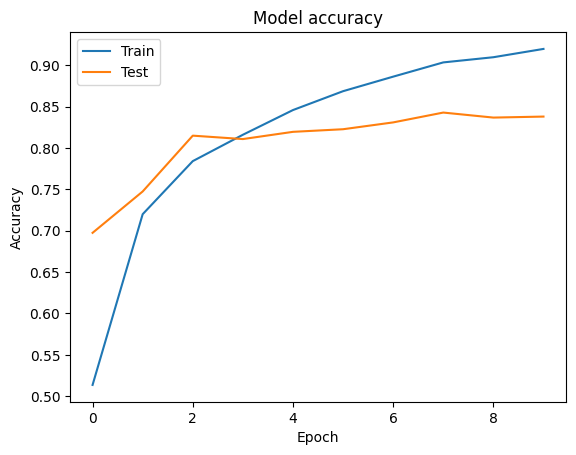

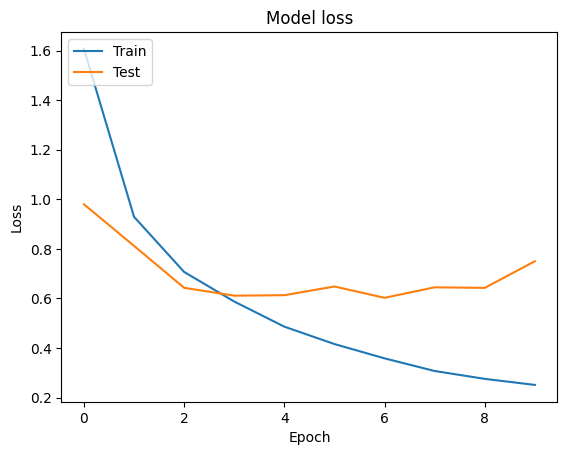

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


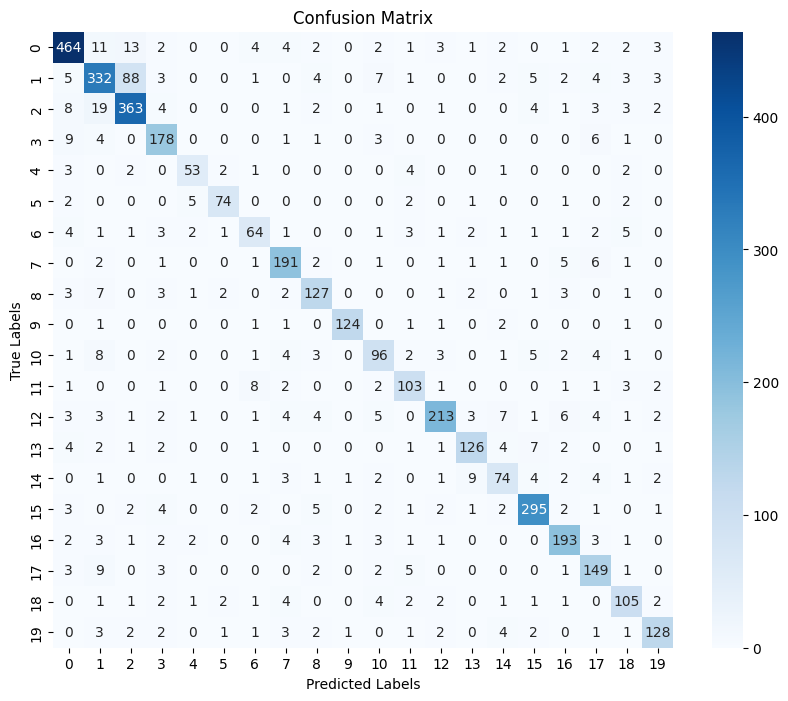

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import os
import numpy as np
from keras.models import load_model
import cv2

# Load the trained model
model_path = '/content/drive/My Drive/trained_model.h5'  # Update with the path to your trained model
model = load_model(model_path)

# Function to load mel spectrogram data
def load_mel_spectrogram(file_path):
    return np.load(file_path)

# Function to preprocess data for prediction
def preprocess_data(spectrogram, target_size=(128, 128)):
    # Resize spectrogram
    resized_spectrogram = cv2.resize(spectrogram, target_size)
    # Add extra dimensions to match model input shape
    resized_spectrogram = np.expand_dims(resized_spectrogram, axis=0)
    resized_spectrogram = np.expand_dims(resized_spectrogram, axis=-1)
    return resized_spectrogram

# Function to make predictions
def predict(model, spectrogram):
    # Preprocess the spectrogram
    preprocessed_spectrogram = preprocess_data(spectrogram)
    # Make prediction
    prediction = model.predict(preprocessed_spectrogram)
    return prediction


spectrogram_file = '/content/drive/My Drive/spectrogram_npy_test/Ardea purpurea/call_17.713523.npy'
# Load the mel spectrogram
mel_spectrogram = load_mel_spectrogram(spectrogram_file)
# Make prediction
prediction = predict(model, mel_spectrogram)
print("Prediction values:", prediction)
class_labels = [
    'Acrocephalus melanopogon','Acrocephalus melanopogon','Acrocephalus scirpaceus',  'Alcedo atthis','Anas platyrhynchos','Anas strepera','Ardea purpurea','Botaurus stellaris',  'Charadrius alexandrinus',
     'Ciconia ciconia','Circus aeruginosus', 'Coracias garrulus', 'Dendrocopos minor', 'Fulica atra','Gallinula chloropus','Himantopus himantopus','Ixobrychus minutus',
    'Motacilla flava','Porphyrio porphyrio','Tachybaptus ruficollis'
]
# Get the index of the class with the highest probability
predicted_class_index = np.argmax(prediction)
# Get the corresponding class label
predicted_class = class_labels[predicted_class_index]
print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 302ms/step
Prediction values: [[1.2498802e-04 2.1700818e-07 7.0445697e-07 3.5494804e-08 1.0967722e-04
  8.3297607e-07 9.9252230e-01 2.0357767e-05 5.7124663e-07 2.9161107e-08
  5.0554050e-08 6.9653275e-03 1.7665885e-04 8.6716312e-07 2.0768363e-08
  3.2993203e-06 4.8420240e-08 6.3047075e-08 7.4101481e-05 1.5282189e-10]]
Predicted class: Ardea purpurea


In [ ]:
spectrogram_file = '/content/drive/My Drive/spectrogram_npy_test/Porphyrio porphyrio/song_11.387172.npy'
# Load the mel spectrogram
mel_spectrogram = load_mel_spectrogram(spectrogram_file)
# Make prediction
prediction = predict(model, mel_spectrogram)
print("Prediction values:", prediction)
class_labels = [
    'Acrocephalus melanopogon','Acrocephalus melanopogon','Acrocephalus scirpaceus',  'Alcedo atthis','Anas platyrhynchos','Anas strepera','Ardea purpurea','Botaurus stellaris',  'Charadrius alexandrinus',
     'Ciconia ciconia','Circus aeruginosus', 'Coracias garrulus', 'Dendrocopos minor', 'Fulica atra','Gallinula chloropus','Himantopus himantopus','Ixobrychus minutus',
    'Motacilla flava','Porphyrio porphyrio','Tachybaptus ruficollis'
]
# Get the index of the class with the highest probability
predicted_class_index = np.argmax(prediction)
# Get the corresponding class label
predicted_class = class_labels[predicted_class_index]
print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 50ms/step
Prediction values: [[3.0832840e-15 3.2521281e-11 1.4819045e-10 1.1460461e-15 1.4212367e-12
  1.3971509e-13 1.2045406e-10 4.0837458e-11 1.5217461e-08 2.4706540e-16
  3.7554553e-11 1.3877340e-12 4.5127652e-11 2.8207971e-11 6.5338746e-12
  1.5077384e-13 1.1900476e-12 3.1859308e-15 9.9999964e-01 3.1528347e-07]]
Predicted class: Porphyrio porphyrio


In [ ]:
spectrogram_file = '/content/drive/My Drive/spectrogram_npy_test/Gallinula chloropus/call_16.61.npy'
# Load the mel spectrogram
mel_spectrogram = load_mel_spectrogram(spectrogram_file)
# Make prediction
prediction = predict(model, mel_spectrogram)
print("Prediction values:", prediction)
class_labels = [
    'Acrocephalus melanopogon','Acrocephalus melanopogon','Acrocephalus scirpaceus',  'Alcedo atthis','Anas platyrhynchos','Anas strepera','Ardea purpurea','Botaurus stellaris',  'Charadrius alexandrinus',
     'Ciconia ciconia','Circus aeruginosus', 'Coracias garrulus', 'Dendrocopos minor', 'Fulica atra','Gallinula chloropus','Himantopus himantopus','Ixobrychus minutus',
    'Motacilla flava','Porphyrio porphyrio','Tachybaptus ruficollis'
]
# Get the index of the class with the highest probability
predicted_class_index = np.argmax(prediction)
# Get the corresponding class label
predicted_class = class_labels[predicted_class_index]
print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 49ms/step
Prediction values: [[1.8440837e-04 2.6377207e-03 3.0617634e-04 4.7611579e-02 3.7277531e-04
  4.8143389e-03 1.4885281e-03 3.4725672e-04 8.1559248e-02 4.3020631e-05
  1.9820939e-01 5.2827334e-05 6.3114474e-03 1.2256324e-01 2.7723414e-01
  2.2308394e-02 4.9466684e-02 3.3888404e-04 1.6523212e-01 1.8917726e-02]]
Predicted class: Gallinula chloropus
